In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
from torch.utils.data import Subset
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

In [3]:
data_dir  = '../Data/Orientation/Data'

classes = os.listdir(data_dir)
classes = [i for i in classes if not i.startswith('.')]
print(classes)

['valid', 'deadlift', 'train']


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((45, 100)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [5]:
target_class_idx = dataset.class_to_idx['deadlift']

In [6]:
target_indices = [idx for idx, (_, class_idx) in enumerate(dataset.samples) if class_idx == target_class_idx]
# Create a Subset dataset containing only samples from the target class
deadlift_class_dataset = Subset(dataset, target_indices)

In [7]:
len(dataset)

498

In [8]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((45, 100)), transforms.ToTensor()])

anomaly = ImageFolder('../Data/Orientation/anomaly', transform = transformations)
len(anomaly)

45

In [9]:
# Get the targets (labels) of all samples in the dataset.
targets = dataset.targets

# Count the occurrences of each target class in the dataset.
class_counts = {}
for target in targets:
    if target in class_counts:
        class_counts[target] += 1
    else:
        class_counts[target] = 1

# Print the number of samples in each class.
for class_label, count in class_counts.items():
    class_name = dataset.classes[class_label]
    print(f"Class '{class_name}' (Label {class_label}): {count} samples")

Class 'deadlift' (Label 0): 249 samples
Class 'train' (Label 1): 199 samples
Class 'valid' (Label 2): 50 samples


In [10]:
from torch.utils.data.dataloader import DataLoader
dataset = DataLoader(dataset, 119, shuffle=True)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class ResNet(ImageClassificationBase):
  #inherit from ImageClassificationBase
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Remove the classification head (fully connected layers) from the model
        self.network = nn.Sequential(*list(self.network.children())[:-2])
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
model = ResNet()

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cpu')

In [16]:
to_device(model, device)

ResNet(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [17]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    
    # Define the flattening layer
    flatten_layer = nn.Flatten()

    # Get predictions from model
    yb = model(xb)
    flattened_features = flatten_layer(yb)
    
    return flattened_features

In [18]:
import pandas as pd
X_deadlift = pd.DataFrame()
X_anomalies = pd.DataFrame()

In [19]:
for img,label in deadlift_class_dataset:
    X_deadlift = X_deadlift.append(pd.Series(to_device(torch.squeeze(predict_image(img,model)),'cpu').detach().numpy()),ignore_index = True)

In [20]:
for img,label in anomaly:
    X_anomalies = X_anomalies.append(pd.Series(to_device(torch.squeeze(predict_image(img,model)),'cpu').detach().numpy()),ignore_index = True)

# PCA

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=200)
pca.fit(X_deadlift)
Scaled_deadlift = pd.DataFrame(pca.transform(X_deadlift))

In [23]:
Scaled_deadlift = Scaled_deadlift.assign(Class='deadlift')
Scaled_deadlift.head()  

,0,1,Class
0,-0.738551,1.544007,deadlift
1,-1.257151,1.425418,deadlift
2,-1.058265,-0.276181,deadlift
3,-0.254568,-0.176072,deadlift
4,0.611928,-0.526251,deadlift


In [24]:
pca = PCA(n_components=2,random_state=200)
pca.fit(X_anomalies)
Scaled_anomalies =pd.DataFrame(pca.transform(X_anomalies))

In [25]:
Scaled_anomalies = Scaled_anomalies.assign(Class='Anomaly')
Scaled_anomalies.head()  

,0,1,Class
0,1.697088,-0.291940,Anomaly
1,0.834183,5.737372,Anomaly
2,2.196367,2.069253,Anomaly
3,0.954289,-1.729153,Anomaly
4,-1.669463,-1.515252,Anomaly


In [26]:
combined = pd.concat([Scaled_deadlift,Scaled_anomalies])
combined.shape

(294, 3)

<Axes: xlabel='0', ylabel='1'>

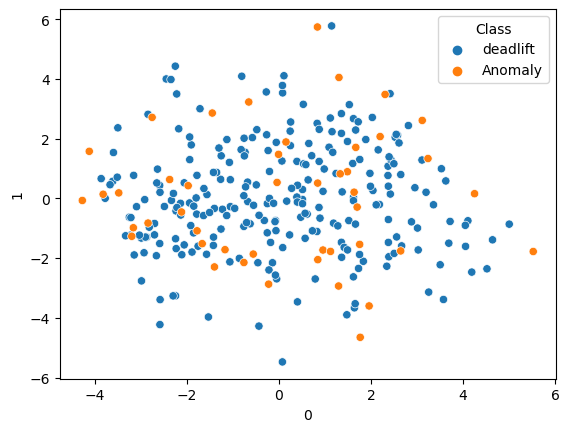

In [28]:
import seaborn as sns
sns.scatterplot(data=combined, x=0, y=1,hue='Class')

# TSNE

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state=200,perplexity=11)
Scaled_deadlift = pd.DataFrame(tsne.fit_transform(X_deadlift))

In [36]:
Scaled_deadlift = Scaled_deadlift.assign(Class='deadlift')
Scaled_deadlift.head() 

,0,1,Class
0,2.848782,-9.973839,deadlift
1,7.418214,-19.326942,deadlift
2,10.213639,-0.222919,deadlift
3,12.120318,23.543449,deadlift
4,8.526162,9.064986,deadlift


In [57]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state=42,perplexity=10)
Scaled_anomalies = pd.DataFrame(tsne.fit_transform(X_anomalies))

In [58]:
Scaled_anomalies = Scaled_anomalies.assign(Class='Anomaly')
Scaled_anomalies.head()   

,0,1,Class
0,-80.192055,57.390190,Anomaly
1,19.181236,-93.702301,Anomaly
2,27.989380,-80.039909,Anomaly
3,13.131793,80.223770,Anomaly
4,-0.875039,49.814919,Anomaly


In [59]:
combined = pd.concat([Scaled_deadlift,Scaled_anomalies])
combined.shape

(294, 3)

<Axes: xlabel='0', ylabel='1'>

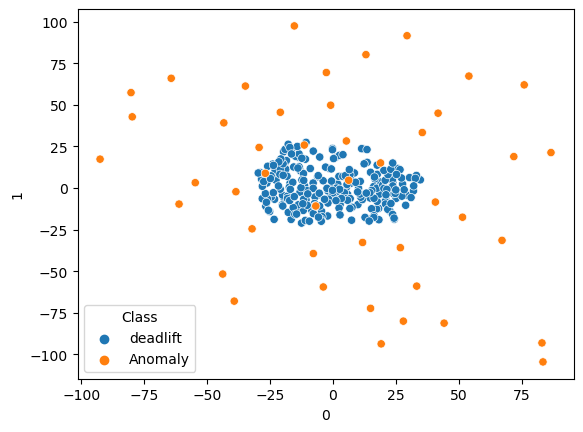

In [60]:
import seaborn as sns
sns.scatterplot(data=combined, x=0, y=1,hue='Class')